In [2]:
from cryoS2Sdrop.analyze import *
from cryoS2Sdrop.deconvolution import tom_deconv_tomo
from skimage import exposure

from cryoS2Sdrop.dataloader import singleCET_dataset, singleCET_FourierDataset, singleCET_ProjectedDataset


PARENT_PATH = setup.PARENT_PATH

pd.options.display.float_format = "{:,.6f}".format
pd.set_option('display.max_columns', 50)

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

def plot_centralSlices(tomo_data, set_axis_off, names=None):
    shape = np.array(tomo_data.shape)
    idx_central_slices = shape//2
    ratios = shape/shape.max()
    
    fig, ax = plt.subplots(1, 3, figsize=(25, 10), gridspec_kw={'width_ratios': ratios})  
    if set_axis_off:
        list(map(lambda axi: axi.set_axis_off(), ax.ravel()))
        
    plt.tight_layout()
    
    if names is None:
        names = ['Central XY plane', 'Central ZX plane', 'Central ZY plane']
    
    for i in range(3):
        tomo_slice = np.take(tomo_data, idx_central_slices[i], axis=i)
        ax[i].imshow(tomo_slice)
        ax[i].set_title(names[i], fontsize=16)
    
    plt.show()
    
    return fig, ax

def make_shell(inner_radius, outer_radius, tomo_shape):
    """
    Creates a (3D) shell with given inner_radius and delta_r width centered at the middle of the array.

    """

    length = min(tomo_shape)
    if length % 2 == 1:
        length = length - 1

    mask_shape = len(tomo_shape) * [length]
    _shell_mask = np.zeros(mask_shape)

    # only do positive quadrant first
    for z in range(0, outer_radius + 1):
        for y in range(0, outer_radius + 1):
            for x in range(0, outer_radius + 1):

                r = np.linalg.norm([z, y, x])

                if r >= inner_radius and r < outer_radius:
                    zidx = z + length // 2
                    yidx = y + length // 2
                    xidx = x + length // 2

                    _shell_mask[zidx, yidx, xidx] = 1

    aux = (
        np.rot90(_shell_mask, axes=(0, 1))
        + np.rot90(_shell_mask, 2, axes=(0, 1))
        + np.rot90(_shell_mask, 3, axes=(0, 1))
    )

    _shell_mask = _shell_mask + aux  # this is half the volume

    aux = np.rot90(
        _shell_mask, 2, axes=(1, 2)
    )  # rotate again 180º to get full volume

    aux2 = _shell_mask + aux

    if inner_radius == 0:
        vol = 4 / 3 * np.pi * outer_radius**3
        pct_diff = (vol - aux2.sum()) / vol
        if pct_diff > 0.1:
            print(pct_diff)
            raise ValueError("Sanity check for sphere volume not passed")

    # finally, fill the actual shape of the tomogram with the mask
    shell_mask = np.zeros(tomo_shape)
    shell_mask[
        (tomo_shape[0] - length) // 2 : (tomo_shape[0] + length) // 2,
        (tomo_shape[1] - length) // 2 : (tomo_shape[1] + length) // 2,
        (tomo_shape[2] - length) // 2 : (tomo_shape[2] + length) // 2,
    ] = aux2

    return shell_mask

def create_hiFreqMask(tomo_shape, fourier_tomo_shape):
    "Randomly mask high frequencies with a sphere"
    inner = 0
    shape_vol = np.array(tomo_shape).prod()
    low_r = (0.05 * 3/(4*np.pi) * shape_vol)**(1/3)
    high_r = (0.1 * 3/(4*np.pi) * shape_vol)**(1/3)
    outer = np.random.uniform(low_r, high_r)
    outer = int(np.round(outer))
    
    shell_mask = make_shell(inner, outer, tomo_shape)
    # up to this point we have a shell for the shifted (centered) full spectrum
    shell_mask = torch.tensor(shell_mask)
    # # make shell correspond to the unshifted spectrum
    # shell_mask = torch.fft.ifftshift(shell_mask)
    # # make it correspond to only real part of spectrum
    # shell_mask = shell_mask[..., 0 : fourier_tomo_shape[-1]]

    return shell_mask.float().numpy()

def create_Vmask(tomo_shape, volumetric_scale_factor):
    "Create volumetric blind spot random mask"
    downsampled_shape = np.array(tomo_shape) // volumetric_scale_factor
    downsampled_shape = tuple(downsampled_shape)

    bernoulli_Vmask = dropoutV(torch.ones(downsampled_shape)) * (
        1 - dropoutV.p
    )
    bernoulli_Vmask = bernoulli_Vmask.unsqueeze(0).unsqueeze(0)
    bernoulli_Vmask = upsample(bernoulli_Vmask)
    
    # adjust for uneven sizes on dimension 0
    diff0 = tomo_shape[0] - bernoulli_Vmask.shape[2]
    if (diff0 > 0) and (diff0 < volumetric_scale_factor):
        extra_row = bernoulli_Vmask[:, :, 0:diff0, ...]
        bernoulli_Vmask = torch.cat([extra_row, bernoulli_Vmask], dim=2)

    return bernoulli_Vmask.squeeze().numpy()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


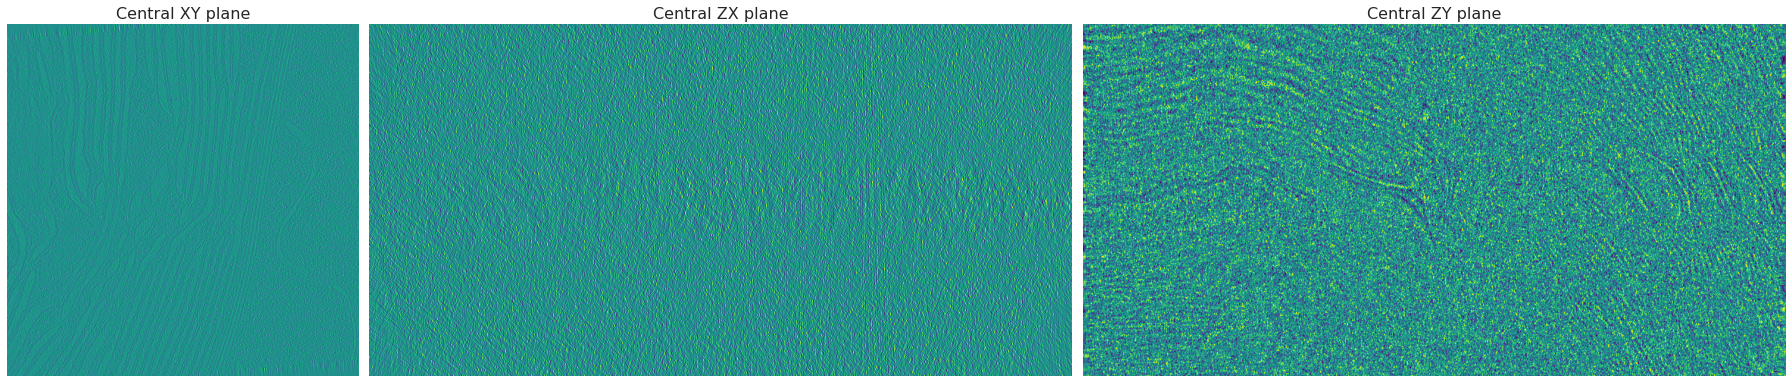

[464 928 928] [464 928 465]


In [9]:
# tomo_name = "tomoPhantom_model14_noisyGaussPoissL"
# tomo_name = "shrec2021_model4_dummy"
# tomo_name = "tomo02"

# cet_path, gt_cet_path = parse_tomoPaths(tomo_name)
# tomo_data, gt_tomo_data = read_array(cet_path), read_array(gt_cet_path)

cet_path = os.path.join(PARENT_PATH, 'data/raw_cryo-ET/tomo02.mrc') 
gt_cet_path = os.path.join(PARENT_PATH, 'data/nnUnet/nifti_files/tomo02_bin4_denoised_0000.nii.gz') 
tomo_data, gt_tomo_data = read_array(cet_path), read_array(gt_cet_path)


tomo_data = standardize(clip(tomo_data))

gt_tomo_data = standardize(clip(gt_tomo_data))

Ftomo_data = torch.fft.rfftn(torch.tensor(tomo_data)).numpy()
fourier_tomo_shape = np.array(Ftomo_data.shape)

tomo_shape = np.array(tomo_data.shape)
fig, ax = plot_centralSlices(tomo_data, set_axis_off=True)

print(tomo_shape, fourier_tomo_shape)

In [11]:
p=0.1
Vmask_p=0.5
batch_size = 8
num_gpus = 2
subtomo_length = 96
Vmask_probability = 0
bernoulliMask_prob=0
input_as_target = False
volumetric_scale_factor = 8

deconv_kwargs = {'angpix': 14,
                 'defocus': 0,
                 'snrfalloff': 1,
                 'deconvstrength': 1,
                 'highpassnyquist': 0.3}

my_dataset = singleCET_FourierDataset(cet_path, subtomo_length, p=p, volumetric_scale_factor=volumetric_scale_factor, gt_tomo_path=gt_cet_path,
                                      Vmask_probability=Vmask_probability, input_as_target=input_as_target, Vmask_pct=Vmask_p, 
                                      bernoulliMask_prob=bernoulliMask_prob, total_samples=5)
print('Size of dataset: %i, Steps per epoch: %i' %(len(my_dataset), len(my_dataset)/(batch_size*num_gpus)))

Creating Fourier samples...



100%|████████████████████████████████████| 1/1 [02:24<00:00, 144.85s/it]


Done! Using 5 Fourier samples.
Size of dataset: 500, Steps per epoch: 31


In [12]:
# mask = my_dataset.highPower_mask
mask = my_dataset.create_mask()[0]
print(mask.sum()/np.array(mask.shape).prod())

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18, 8))

aux_idx = [0, 0, 0]
ax0.imshow(mask[aux_idx[0]])
ax1.imshow(mask[:,aux_idx[1], :])
ax2.imshow(mask[:, :,aux_idx[2]])

tensor(0.4380)


In [16]:
power_spectrum = np.log(np.abs(Ftomo_data**2))

In [17]:
plot_centralSlices(power_spectrum, True)

(<Figure size 1800x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Central XY plane'}>,
        <AxesSubplot:title={'center':'Central ZX plane'}>,
        <AxesSubplot:title={'center':'Central ZY plane'}>], dtype=object))

In [ ]:
Fsample = torch.tensor(mask*Ftomo_data)
Fsample = torch.ifftn(Fsample, )